In [1]:
from io import StringIO
import psycopg2
import pandas as pd

MY_USER = 'postgres'
MY_DB = 'db_mno'
MY_HOST = 'database-rita.cnevbxmlm0lp.us-west-2.rds.amazonaws.com'
MY_PASS = '1234567890'
MY_PORT = 5432

def get_data(query):
    try:
        connection = psycopg2.connect(user=MY_USER , # Usuario RDS
                                     password=MY_PASS, # password de usuario de RDS
                                     host=MY_HOST ,#"127.0.0.1", # cambiar por el endpoint adecuado
                                     port=MY_PORT, # cambiar por el puerto
                                     database=MY_DB ) # Nombre de la base de datos
        cursor = connection.cursor()

        cursor.execute(query)

        print("Selecting rows from table using cursor.fetchall")
        records = cursor.fetchall()
        df = pd.DataFrame(records)
        col_names =  [i[0] for i in cursor.description]
        df.columns = col_names
        cursor.close()
        connection.close()
        print("PostgreSQL connection is closed")
        return df

    except (Exception, psycopg2.Error) as error :
        print ("Error while fetching data from PostgreSQL", error)


query = "SELECT * FROM trabajo.fuerza_ventas; "
df = get_data(query)
#print(df.head(10))

Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed


In [2]:
import random
from operator import attrgetter
import time
import copy as cp
import dask
import pandas as pd

In [3]:
from dask.distributed import Client, progress

client = Client()
client

Client Scheduler: tcp://127.0.0.1:57502 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 8.42 GB


In [4]:
def convert(ruta): 
    s = [str(i) for i in ruta] 
    ruta_c = "-".join(s)
    return(ruta_c) 

In [5]:
class Utileria():

    # Función para calcular la distancia entre coordenadas en la tierra (esfera)
    # Recibe las coordenaas del punto A, del punto B y las unidades en las que se realizará el cálculo
    # Devuelve la distancia de acuerdo a la unidad especificada (por defecto km)
    def calcular_distancia_coord(self, nbr_LongA, nbr_LatA, nbr_LongB, nbr_LatB, str_unidad='km'):
        from math import radians, cos, sin, asin, sqrt

        # primero se convierte todo a radianes
        nbr_LongA = radians(nbr_LongA)
        nbr_LatA = radians(nbr_LatA)
        nbr_LongB = radians(nbr_LongB)
        nbr_LatB = radians(nbr_LatB)

        # Aplicamos la fórmula de Haversine
        nbr_delta_lon = nbr_LongB - nbr_LongA
        nbr_delta_lat = nbr_LatB - nbr_LatA
        nbr_a = sin(nbr_delta_lat / 2)**2 + cos(nbr_LatA) * cos(nbr_LatB) * sin(nbr_delta_lon / 2)**2

        nbr_c = 2 * asin(sqrt(nbr_a))

        # Dependiendo del tipo de unidad especificada, sera el valor que usaremos como radio
        # La tierra no es una esfera perfecta, asi que usaremos un radio entre el ecuatorial y el polar
        if str_unidad == 'km':
            nbr_r = 6371
        elif str_unidad == 'miles':
            nbr_r = 3956
        else:
            print('Se especificó una unidad de medición no válida. No es posible realizar el cálculo')
            return 0

        nbr_resultado = nbr_c * nbr_r

        return nbr_resultado


In [6]:
def ruta(df, fv):
    df1 = df[(df.fza_ventas == fv)]
    dfo = df1.filter(['fza_ventas', 'id_origen', 'lat_origen', 'lon_origen'], axis=1).drop_duplicates()
    dfo = dfo.rename({'id_origen': 'id', 'lat_origen': 'lat', 'lon_origen': 'lon'}, axis=1)
    dfd = df1.filter(['fza_ventas', 'no_cliente', 'lat_destino','lon_destino'], axis=1)
    dfd = dfd.rename({'no_cliente': 'id', 'lat_destino': 'lat', 'lon_destino': 'lon'}, axis=1)
    df2 = pd.concat([dfo, dfd])
    df2['posicion'] = 0
    df2['posicion'] = df2.groupby(['posicion']).cumcount()+1
    return df2
    
def distance_matrix(df, fv):
    df2=ruta(df, fv)
    dm = []
    #ut=Utileria()
    for i in range(df2.shape[0]):
        for j in range(i+1, df2.shape[0]):
            d=ut.calcular_distancia_coord(df2.iloc[i, 3], df2.iloc[i, 2],  df2.iloc[j, 3], df2.iloc[j, 2])
            elemento = [df2.iloc[i,4], df2.iloc[j,4], d]
            dm.append(elemento)
    return dm, df2

In [7]:
class Particula():

    list_CaminoActual = []
    list_MejorCamino = []
    nbr_CostoCaminoActual = 0
    nbr_CostoMejorCamino = 0
    velocidad = []

    def __init__(self, par_camino, par_costo):

        self.list_CaminoActual = par_camino
        self.list_MejorCamino = par_camino
        self.nbr_CostoCaminoActual = par_costo
        self.nbr_CostoMejorCamino = par_costo
        self.velocidad = []

In [8]:
class Grafo():

    dict_Nodos = {}
    conj_Nodos = set()  # No hay repeticiones
    nbr_CantNodos = 0
    df_Grafo = None

    def __init__(self, par_df):
        self.df_Grafo = par_df
        self.GenerarGrafo()
        self.nbr_CantNodos = len(self.conj_Nodos)

    def GenerarGrafo(self):

        # Barremos las filas del data frame para generar el grafo
        for fila in self.df_Grafo:
            # Las distacias son las mismas en ambos sentidos
            self.AgregarNodoAGrafo(fila[0], fila[1], fila[2])
            self.AgregarNodoAGrafo(fila[1], fila[0], fila[2])

    def AgregarNodoAGrafo(self, par_Origen, par_Destino, par_Costo):

        if not self.ExisteNodo(par_Origen, par_Destino):
            self.dict_Nodos[(par_Origen, par_Destino)] = par_Costo
            self.conj_Nodos.add(par_Origen)
            self.conj_Nodos.add(par_Destino)

    def ExisteNodo(self, par_Origen, par_Destino):
        if (par_Origen, par_Destino) in self.dict_Nodos:
            return True
        else:
            return False

    def MostrarGrafo(self):
        print('Grafo:\n')
        for Nodo in self.dict_Nodos:
            print('%d conectado con: %d. Costo: %d' % (Nodo[0], Nodo[1], self.dict_Nodos[Nodo]))

    def CostoDelCamino(self, camino):

        nbr_CostoTotal = 0
        for i in range(self.nbr_CantNodos - 1):
            nbr_CostoTotal += self.dict_Nodos[(camino[i], camino[i+1])]

        nbr_CostoTotal += self.dict_Nodos[(camino[self.nbr_CantNodos - 1], camino[0])]
        return nbr_CostoTotal

    def GenerarCaminosAleatorios(self, max_size):

        list_CaminosAleatorio, list_Nodos = [], list(self.conj_Nodos)

        initial_vertice = random.choice(list_Nodos)

        list_Nodos.remove(initial_vertice)
        list_Nodos.insert(0, initial_vertice)

        for i in range(max_size):
            list_temp = list_Nodos[1:]
            random.shuffle(list_temp)
            list_temp.insert(0, initial_vertice)

            if list_temp not in list_CaminosAleatorio:
                list_CaminosAleatorio.append(list_temp)

        return list_CaminosAleatorio

In [9]:
class ParticleSwarm():

    # Atributos generales para la ejecución
    df_Datos = ''
    str_TipoEjec = ''

    # Hiperparámetros del algoritmo
    nbr_Iteraciones = 0
    nbr_CantPartic = 0
    nbr_Alfa = 0
    nbr_Beta = 0

    # Atributos de resultados de la ejecución
    nbr_TiempoEjec = 0
    nbr_MejorCosto = 0
    lst_MejorCamino = []

    # Atributo auxiliar
    list_Particulas = []

    def __init__(self, par_Datos, par_TipoEjec, par_HiperParam):

        # Datos y tipo de ejecución
        self.df_Datos = par_Datos
        self.str_TipoEjec = par_TipoEjec

        # Hiperparámetros del algoritmo
        self.nbr_Iteraciones = par_HiperParam.get('Iteraciones')
        self.nbr_CantPartic = par_HiperParam.get('Particulas')
        self.nbr_Alfa = par_HiperParam.get('Alfa')
        self.nbr_Beta = par_HiperParam.get('Beta')

        #################

        self.Grafo = Grafo(self.df_Datos)
        list_CaminosAleatorios = self.Grafo.GenerarCaminosAleatorios(self.nbr_CantPartic)
        for list_CaminoAleatorio in list_CaminosAleatorios:
            particula = Particula(list_CaminoAleatorio, self.Grafo.CostoDelCamino(list_CaminoAleatorio))
            self.list_Particulas .append(particula)

        # updates "size_population"
        self.nbr_CantPartic = len(self.list_Particulas)

    def Ejecutar(self):

        # Tomamos la hora de inicio
        tm_inicio = time.time()

        # Se corre el algorimto secuencial o en paralelo según los parámetros
        if self.str_TipoEjec == 'SEQ':
            self.Secuencial()
        elif self.str_TipoEjec == 'PAR':
            self.Paralelo()
            
        self.lst_MejorCamino = self.obj_MejorParticula.list_MejorCamino
        self.nbr_MejorCosto = self.obj_MejorParticula.nbr_CostoMejorCamino

        # Se toma la hora de fin del algoritmo, y se almacena la duración
        tm_final = time.time()
        self.nbr_TiempoEjec = tm_final - tm_inicio

    def Secuencial(self):

        for t in range(self.nbr_Iteraciones):

            self.obj_MejorParticula = min(self.list_Particulas, key=attrgetter('nbr_CostoMejorCamino'))

            for particula in self.list_Particulas:

                particula = self.ProcesoXParticula(particula, self.obj_MejorParticula)

    def Paralelo(self):

        # Por ejemplo
        for t in range(self.nbr_Iteraciones):

            self.obj_MejorParticula = min(self.list_Particulas, key=attrgetter('nbr_CostoMejorCamino'))

            list_Particulas_Temp = []
            for particula in self.list_Particulas:

                dask_Particula = self.ProcesoXParticulaParalelo(particula, self.obj_MejorParticula)
                list_Particulas_Temp.append(dask_Particula)

            dask_Dummy1 = self.JuntarParticulas(list_Particulas_Temp)
            dask_Dummy2 = dask_Dummy1.compute()
            list_Final = dask_Dummy2[0]
            self.list_Particulas = list_Final

    @dask.delayed
    def JuntarParticulas(self, *argv):
        return argv

    @dask.delayed
    def ProcesoXParticulaParalelo(self, particle, par_gbest):
        return self.ProcesoXParticula(particle, par_gbest)

    def ProcesoXParticula(self, particula, par_gbest):

        # time.sleep(.01)
        del particula.velocidad[:]

        list_VelocidadTemp = []
        list_MejorCaminoGlob = cp.copy(self.obj_MejorParticula.list_MejorCamino)
        list_MejorCaminoPart = particula.list_MejorCamino[:]
        list_CaminoParticula = particula.list_CaminoActual[:]

        list_VelocidadTemp_p = self.Swap(list_CaminoParticula, list_MejorCaminoPart, self.nbr_Alfa)

        list_VelocidadTemp_g = self.Swap(list_CaminoParticula, list_MejorCaminoGlob, self.nbr_Beta)

        list_VelocidadTemp_t = self.JuntarListasSwaps(list_VelocidadTemp_p, list_VelocidadTemp_g)
        list_VelocidadTemp = list_VelocidadTemp_t

        particula.velocidad = list_VelocidadTemp

        # Generación de nuevo camino para la particula
        for tup_Swarm in list_VelocidadTemp:

            if random.random() <= tup_Swarm[2]:
                aux = list_CaminoParticula[tup_Swarm[0]]
                list_CaminoParticula[tup_Swarm[0]] = list_CaminoParticula[tup_Swarm[1]]
                list_CaminoParticula[tup_Swarm[1]] = aux

        particula.list_CaminoActual = list_CaminoParticula
        nbr_CostoCaminoActual = self.Grafo.CostoDelCamino(list_CaminoParticula)
        particula.nbr_CostoCaminoActual = nbr_CostoCaminoActual

        if nbr_CostoCaminoActual < particula.nbr_CostoMejorCamino:
            particula.list_MejorCamino = list_CaminoParticula
            particula.nbr_CostoMejorCamino = nbr_CostoCaminoActual

        return particula

    # @dask.delayed
    def Swap(self, par_CaminoParticula, par_MejorCamino, par_AlphaBeta):
        list_VelocidadTemp = []
        for i in range(self.Grafo.nbr_CantNodos):
            if par_CaminoParticula[i] != par_MejorCamino[i]:

                tup_Swarm = (i, par_MejorCamino.index(par_CaminoParticula[i]), par_AlphaBeta)
                list_VelocidadTemp.append(tup_Swarm)

                # Hacemos el intercambio
                aux = par_MejorCamino[tup_Swarm[0]]
                par_MejorCamino[tup_Swarm[0]] = par_MejorCamino[tup_Swarm[1]]
                par_MejorCamino[tup_Swarm[1]] = aux

        return list_VelocidadTemp

    # @dask.delayed
    def JuntarListasSwaps(self, list1, list2):
        total = list1 + list2
        return total

In [10]:
df.head()

,fza_ventas,no_cliente,lat_destino,lon_destino,id_origen,estado,lat_origen,lon_origen
0,123,10295095,25.7848,-100.398,11388,Nuevo León,25.7789,-100.387
1,123,1010290203,25.7839,-100.395,11388,Nuevo León,25.7789,-100.387
2,123,1010290279,25.7779,-100.400,11388,Nuevo León,25.7789,-100.387
3,123,1010291206,25.7624,-100.395,11388,Nuevo León,25.7789,-100.387
4,123,1010291416,25.7733,-100.410,11388,Nuevo León,25.7789,-100.387


In [11]:
ut=Utileria()
fv = 20240
#1143 3 puntos
#94459 6 puntos
#17147 9 puntos
#20240 2 puntos dobles
dm,df2=distance_matrix(df, fv)

In [12]:
df2

,fza_ventas,id,lat,lon,posicion
1116,20240,11326,25.6409,-100.089,1
1116,20240,1008232009,25.5881,-100.012,2
1117,20240,1008232105,25.5797,-100.009,3
1118,20240,1008232217,25.5689,-100.028,4
1119,20240,1008232222,25.5773,-100.014,5
1120,20240,1008232223,25.5729,-100.009,6
1121,20240,1008232500,25.6323,-100.035,7
1122,20240,1008233352,25.5782,-100.010,8
1123,20240,1020211168,25.5772,-100.017,9
1124,20240,1020268099,25.5780,-100.016,10


In [13]:
rutas = pd.DataFrame(index=range(10),columns=['Costo', 'Tiempo', 'Ruta', 'Ruta2'])
rutas

,Costo,Tiempo,Ruta,Ruta2
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN


In [14]:
######################################## Código para hacer pruebas ########################################

# Para recibir este dataframe, sólo dime en qué formato me lo mandas, y
# adapto la clase para leerlo.
#df_Dummy = [[1, 2, 1.445375218],
#            [1, 3, 8.855215471],
#            [1, 4, 8.14387567],
#            [2, 3, 7.598907453], 
#            [2, 4, 6.980045187],
#            [3, 4, 1.138791437]
#            ]

dict_Hiper = {'Iteraciones': 10,
              'Particulas': 10,
              'Alfa': .9,
              'Beta': 1
              }

# Instanciamos el objeto
for i in range(10):
    PS = ParticleSwarm(dm, 'SEQ', dict_Hiper)
# PS = ParticleSwarm(df_Dummy, 'PAR', dict_Hiper)
# PS.Grafo.MostrarGrafo()
# Se ejecuta el algoritmo


    PS.Ejecutar()
    rutas.Costo[i] = PS.nbr_MejorCosto
    rutas.Tiempo[i] = PS.nbr_TiempoEjec
    rutas.Ruta[i] = convert(PS.lst_MejorCamino)
    rutas.Ruta2[i]=PS.lst_MejorCamino
    #mejor_ruta=PS.lst_MejorCamino

# Ya que terminó, se pueden obtener los resultados de la corrida:
    #print('PS.nbr_TiempoEjec: ', PS.nbr_TiempoEjec)
    #print('PS.nbr_MejorCosto: ', PS.nbr_MejorCosto)
    #print('PS.lst_MejorCamino: ', PS.lst_MejorCamino)

### Análisis de las rutas, tiempos de ejecución y costos

In [15]:
rutas

,Costo,Tiempo,Ruta,Ruta2
0,33.5438,0.00199437,10-5-8-3-7-1-9-11-14-13-2-12-4-6,"[10, 5, 8, 3, 7, 1, 9, 11, 14, 13, 2, 12, 4, 6]"
1,31.8979,0.00398874,6-3-11-13-1-7-2-8-9-14-12-4-10-5,"[6, 3, 11, 13, 1, 7, 2, 8, 9, 14, 12, 4, 10, 5]"
2,31.3997,0.0149615,6-4-14-13-1-7-2-10-5-3-12-11-9-8,"[6, 4, 14, 13, 1, 7, 2, 10, 5, 3, 12, 11, 9, 8]"
3,30.045,0.00891352,6-14-11-13-1-7-2-8-5-3-12-4-9-10,"[6, 14, 11, 13, 1, 7, 2, 8, 5, 3, 12, 4, 9, 10]"
4,28.7431,0.0100117,6-13-14-11-1-7-2-3-8-10-12-4-9-5,"[6, 13, 14, 11, 1, 7, 2, 3, 8, 10, 12, 4, 9, 5]"
5,28.7431,0.0100121,6-13-14-11-1-7-2-3-8-10-12-4-9-5,"[6, 13, 14, 11, 1, 7, 2, 3, 8, 10, 12, 4, 9, 5]"
6,28.7431,0.00897551,6-13-14-11-1-7-2-3-8-10-12-4-9-5,"[6, 13, 14, 11, 1, 7, 2, 3, 8, 10, 12, 4, 9, 5]"
7,28.1397,0.00997305,10-13-14-11-1-7-2-3-8-6-12-4-9-5,"[10, 13, 14, 11, 1, 7, 2, 3, 8, 6, 12, 4, 9, 5]"
8,28.1397,0.0119681,10-13-14-11-1-7-2-3-8-6-12-4-9-5,"[10, 13, 14, 11, 1, 7, 2, 3, 8, 6, 12, 4, 9, 5]"
9,27.7725,0.012965,12-13-14-11-1-7-2-3-8-6-5-4-9-10,"[12, 13, 14, 11, 1, 7, 2, 3, 8, 6, 5, 4, 9, 10]"


In [16]:
rutas['Costo']=rutas['Costo'].astype(float);
rutas['Tiempo']=rutas['Tiempo'].astype(float);

In [17]:
rutas.head()

,Costo,Tiempo,Ruta,Ruta2
0,33.543812,0.001994,10-5-8-3-7-1-9-11-14-13-2-12-4-6,"[10, 5, 8, 3, 7, 1, 9, 11, 14, 13, 2, 12, 4, 6]"
1,31.897932,0.003989,6-3-11-13-1-7-2-8-9-14-12-4-10-5,"[6, 3, 11, 13, 1, 7, 2, 8, 9, 14, 12, 4, 10, 5]"
2,31.399717,0.014961,6-4-14-13-1-7-2-10-5-3-12-11-9-8,"[6, 4, 14, 13, 1, 7, 2, 10, 5, 3, 12, 11, 9, 8]"
3,30.045000,0.008914,6-14-11-13-1-7-2-8-5-3-12-4-9-10,"[6, 14, 11, 13, 1, 7, 2, 8, 5, 3, 12, 4, 9, 10]"
4,28.743128,0.010012,6-13-14-11-1-7-2-3-8-10-12-4-9-5,"[6, 13, 14, 11, 1, 7, 2, 3, 8, 10, 12, 4, 9, 5]"


In [ ]:
rutas.describe()

Text(0.5,0,'KM')

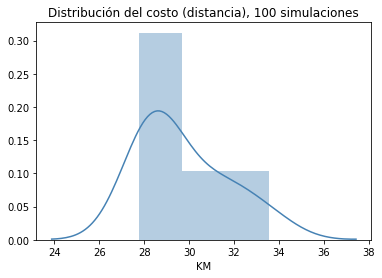

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(rutas.Costo, color="steelblue")
plt.title('Distribución del costo (distancia), 100 simulaciones')
plt.xlabel('KM', fontsize=10)

Text(0.5,0,'Tiempo')

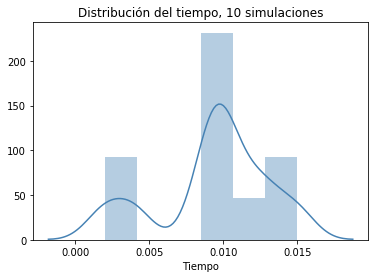

In [20]:
sns.distplot(rutas.Tiempo, color="steelblue")
plt.title('Distribución del tiempo, 10 simulaciones')
plt.xlabel('Tiempo', fontsize=10)

In [21]:
resumen = rutas.groupby('Ruta').size().reset_index(name='Count').rename(columns={'Col1':'Col_value'})
resumen

,Ruta,Count
0,10-13-14-11-1-7-2-3-8-6-12-4-9-5,2
1,10-5-8-3-7-1-9-11-14-13-2-12-4-6,1
2,12-13-14-11-1-7-2-3-8-6-5-4-9-10,1
3,6-13-14-11-1-7-2-3-8-10-12-4-9-5,3
4,6-14-11-13-1-7-2-8-5-3-12-4-9-10,1
5,6-3-11-13-1-7-2-8-9-14-12-4-10-5,1
6,6-4-14-13-1-7-2-10-5-3-12-11-9-8,1


In [22]:
def Convert(string): 
    li = list(string.split("-")) 
    return li 

In [23]:
import numpy as np
a = Convert(resumen.loc[0, 'Ruta'])
a= list(np.int_(a))

b  =  Convert(resumen.loc[3, 'Ruta'])
b= list(np.int_(b))

print(a) 
print(b)

[10, 13, 14, 11, 1, 7, 2, 3, 8, 6, 12, 4, 9, 5]
[6, 13, 14, 11, 1, 7, 2, 3, 8, 10, 12, 4, 9, 5]


#### Visualización de la ruta

In [23]:
# preparación de datos para creación de mapa
import folium
def vis_mapa(df, mejor_ruta):
    df=df.set_index('posicion')
    df=df.reindex(mejor_ruta)
    coordenadas = df[['lat', 'lon']].values.tolist()
    os = df.loc[[1], ['lat', 'lon']].values.tolist() #Definición de punto: Oficina de servicio
    cen_lon = df.lon.mean()
    cen_lat = df.lat.mean()
    mapi = folium.Map(location=[cen_lat,cen_lon],
                  zoom_start = 12,
                  tiles="cartodbpositron")
    folium.PolyLine(coordenadas + [coordenadas[0]],
                color='red',
                weight=1,
                opacity=0.8).add_to(mapi)
    folium.Marker(os[0],icon=folium.Icon(color='blue') ).add_to(mapi)

    return mapi




In [21]:
mejor_ruta

[3, 2, 7, 10, 1, 4, 5, 6, 8, 9]

In [ ]:
df2

In [24]:
vis_mapa(df2, mejor_ruta)

### Ejemplo de dos rutas

In [25]:
import folium

In [26]:
# dos diferentes rutas
df0=df2.set_index('posicion')

# ruta 1
df1=df0.reindex(a)
coordenadas1 = df1[['lat', 'lon']].values.tolist()

df3=df0.reindex(b)
coordenadas2 = df3[['lat', 'lon']].values.tolist()


os = df0.loc[[1], ['lat', 'lon']].values.tolist()#Definición de punto: Oficina de servicio
cen_lon = df0.lon.mean()
cen_lat = df0.lat.mean()
mapi = folium.Map(location=[cen_lat,cen_lon],
                  zoom_start = 12,
                  tiles= "OpenStreetMap")
folium.PolyLine(coordenadas1 + [coordenadas1[0]],
                color='red',
                weight=2,
                opacity=0.8).add_to(mapi)
folium.Marker(os[0], icon=folium.Icon(color='blue', icon='cloud') ).add_to(mapi)

folium.PolyLine(coordenadas2 + [coordenadas2[0]],
                color='blue',
                weight=1.5,
                opacity=1).add_to(mapi)
#N = 14
#popups = [str(i) for i in range(14)] # Popups texts are simple numbers.

#plugins.MarkerCluster(coordenadas1, popups=popups).add_to(mapi)

mapi